# Advanced Modeling

In this notebook we will go deep on advanced modeling concepts. We will go over common pitfalls and best practices that are idiosyncratic to quant finance and Numerai. 

1. Risky Features: measuring feature risk and identifying risky features    
2. Auxilary Targets: what are auxiliary targets and how to use them 
3. Overlapping Eras: the problem with leakage and how to fix it with embargos

In [58]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle seaborn

## 1. Risky Features 

In the previous Model Diagnostics notebook, we explored the idea of `Feature Exposure` as a risk and `Feature neutralization` as the way to control this risk and improve performance. 

But how risky are features exactly? Can we quantify this risk associated with each feature?

In [59]:
from numerapi import NumerAPI
import json
import pandas as pd
napi = NumerAPI()

# Download the training data and feature metadata
napi.download_dataset("v4.1/train.parquet");
napi.download_dataset("v4.1/features.json");

# Use the "small" feature set again
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + feature_cols + ["target"])

2023-04-26 15:22:57,491 INFO numerapi.utils: target file already exists
2023-04-26 15:22:57,492 INFO numerapi.utils: download complete
2023-04-26 15:22:57,957 INFO numerapi.utils: target file already exists
2023-04-26 15:22:57,959 INFO numerapi.utils: download complete


Recall that `Feature Exposure` is measured by the <ins>correlation between features and our predictions</ins>. Having a high feature exposure means we are at risk of poor/negative performance if the features we are exposed to stops being predictive or reverses.

But to measure feature risk, we need to look at the <ins>the correlation between features and the target</ins>.

In [60]:
import numpy as np

# Compute the per-era correlation to the target for each feature
feature_correlations_with_target = pd.DataFrame(index=training_data.era.unique())
for feature_name in feature_cols:
    feature_correlations_with_target[feature_name] = training_data.groupby("era").apply(lambda d: np.corrcoef(d[feature_name], d["target"])[0,1])

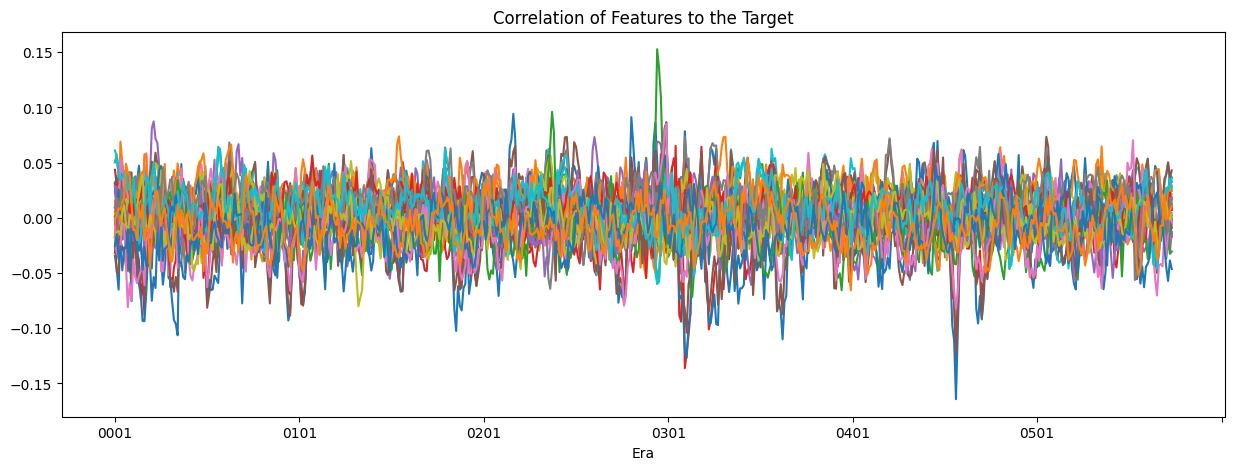

In [61]:
# Plot the per-era correlation
feature_correlations_with_target.plot(figsize=(15, 5), title="Correlation of Features to the Target", legend=False, xlabel="Era");

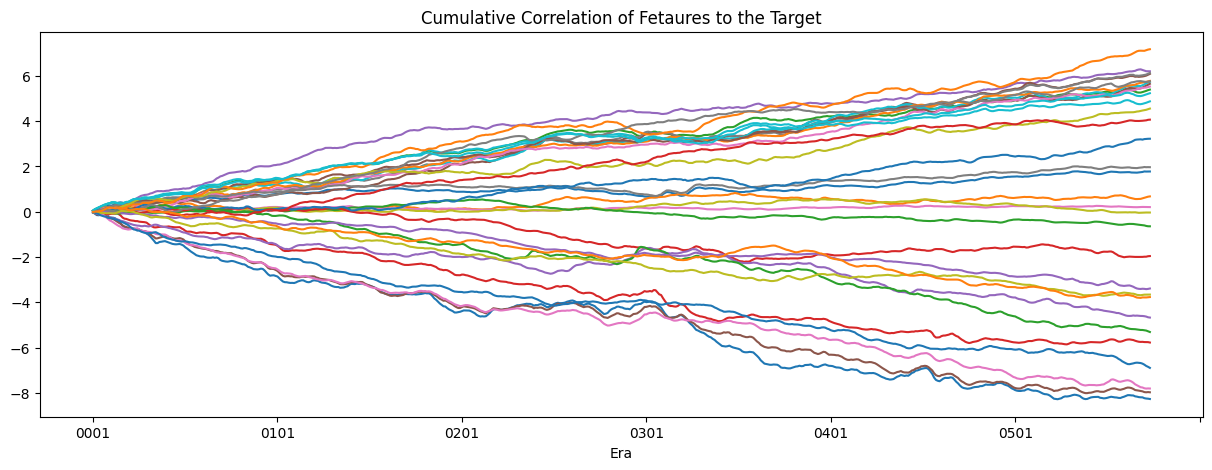

In [62]:
# Plot the cumulative per-era correlation
feature_correlations_with_target.cumsum().plot(figsize=(15, 5), title="Cumulative Correlation of Fetaures to the Target", legend=False, xlabel="Era");

It is important to note that having negative cumulative correlation alone does not imply that a feature is high risk. In fact it is very possible for a feature to be considered to be low risk if it has consistent negative correlation.

There is no right way to measure feature risk, but here are two ways that could be useful beyond the risk metrics discussed previously.
- by the standard deviation of correlation with the target 
- by the absolute change of mean correlation between first and second second half of the training data 

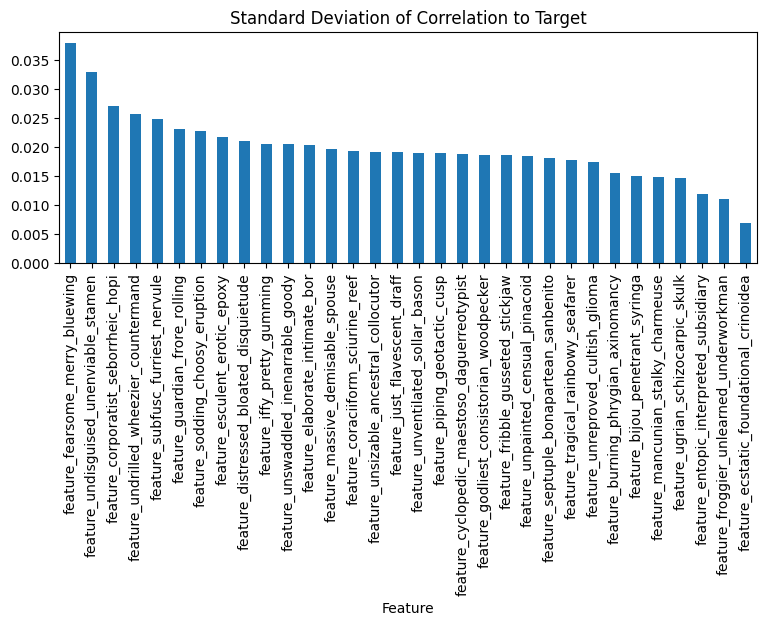

In [63]:
# Rank features by std dev of correlation to the target
# The higher the std dev, the more the correlation varies over time, the riskier the feature
feature_correlations_with_target.std().sort_values(ascending=False).plot.bar(figsize=(9, 3), title="Standard Deviation of Correlation to Target", xlabel="Feature");

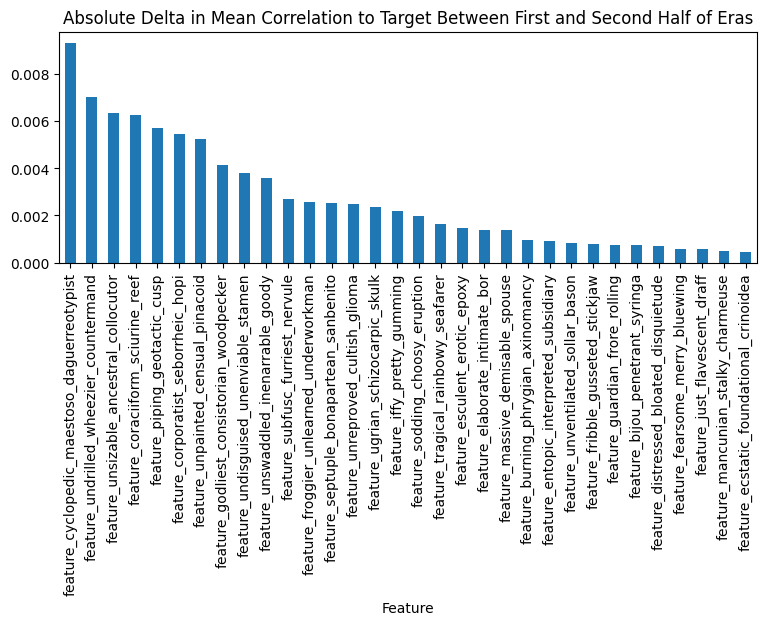

In [64]:
# Rank features by the absolute delta in correlation to the target between first half and second half of eras 
# The higher the delta, the more the correlation varies over time, the riskier the feature

# divide eras into two halves
eras = training_data.era.unique()
eras_first_half = eras[:len(eras)//2]
eras_second_half = eras[len(eras)//2:]

# take feature_correlations_with_target and split it into two halves
# compute the mean correlation for each feature in each half
# compute the delta for each feature between the two halves
# rank featuers by the absolute value of the delta
feature_correlations_with_target_first_half = feature_correlations_with_target.loc[eras_first_half].mean()
feature_correlations_with_target_second_half = feature_correlations_with_target.loc[eras_second_half].mean()
feature_correlations_with_target_delta = (feature_correlations_with_target_first_half - feature_correlations_with_target_second_half).abs()
feature_correlations_with_target_delta.sort_values(ascending=False).plot.bar(figsize=(9, 3), title="Absolute Delta in Mean Correlation to Target Between First and Second Half of Eras", xlabel="Feature");

## 2. Auxiliary Targets
So far we have learned about "the target" in the Numerai dataset. But there are actually many targets in the Numerai dataset.

Recall that `target` is a measure of "20 day subsequent stock-specific return". "Subsequent" here means that it is forward-looking. And "stock-specific" means that we want to focus on returns that are not "explained" by the overall returns of a sector or a region or the entire market. This is sometimes referred to as "alpha".  

In quant finance, it is often helpful to train machine learning models on different types of stock-specific returns even if you ultimately trying to predict a specific one. In Numerai, we have created a number of auxiliary targets that represent different kinds of stock-specific returns which we think could be help us predict the `target`.

In [65]:
import pandas as pd
import json

# Feature metadata contains the names of all the targets 
feature_metadata = json.load(open("v4.1/features.json")) 
target_cols = feature_metadata["targets"]

# Load the validation data but only the target columns
training_data = pd.read_parquet("v4.1/train.parquet", columns=["era"] + target_cols)

In [66]:
# Let's take a look at the targets
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 7)
training_data

,era,target,target_nomi_v4_20,...,target_sam_v4_60,target_xerxes_v4_20,target_xerxes_v4_60
id,,,,,,,
n003bba8a98662e4,0001,0.25,0.25,...,0.25,0.25,0.25
n003bee128c2fcfc,0001,0.75,0.75,...,0.75,0.75,0.75
n0048ac83aff7194,0001,0.50,0.50,...,0.25,0.25,0.25
n00691bec80d3e02,0001,0.75,0.75,...,0.50,0.75,0.50
n00b8720a2fdc4f2,0001,0.75,0.75,...,0.50,0.50,0.50
...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,...,1.00,0.75,1.00
nffd71b7f6a128df,0574,0.00,0.00,...,0.25,0.00,0.50
nffde3b371d67394,0574,0.25,0.25,...,0.75,0.50,0.75


In [67]:
# The first thing to notice here is that `target` is exactly the same as `target_nomi_v4_20`
# This means that `target_nomi_v4_20` is currently the target used for scoring but this might change in the future!
print(training_data["target"].equals(training_data["target_nomi_v4_20"]))

# For the rest of this analaysis we can ignore the `target` column
target_names = target_cols[1:]
targets_df = training_data[["era"] + target_names]

True


In [68]:
# A good way to visualize all the different targets is by grouping them by their name and time horizon suffix
pd.set_option('display.max_rows', 100)
names = list(set([t[7:-6] for t in target_names]))
t20s = [t for t in target_names if t.endswith("_20")]
t60s = [t for t in target_names if t.endswith("_60")]
pd.DataFrame({"name": names,"20": t20s,"60": t60s}).set_index("name")

,20,60
name,,
nomi,target_nomi_v4_20,target_nomi_v4_60
waldo,target_tyler_v4_20,target_tyler_v4_60
ben,target_victor_v4_20,target_victor_v4_60
william,target_ralph_v4_20,target_ralph_v4_60
george,target_waldo_v4_20,target_waldo_v4_60
alan,target_jerome_v4_20,target_jerome_v4_60
sam,target_janet_v4_20,target_janet_v4_60
thomas,target_ben_v4_20,target_ben_v4_60
caroline,target_alan_v4_20,target_alan_v4_60


At a high level, each target represents a kind of stock market return at a different time horizon
- each `name` represents a different kind of stock market return (eg. return relative to country and sector)
- the `_20` or `_60` suffix denotes the time horizon of the target (eg. 20 or 60 market days)

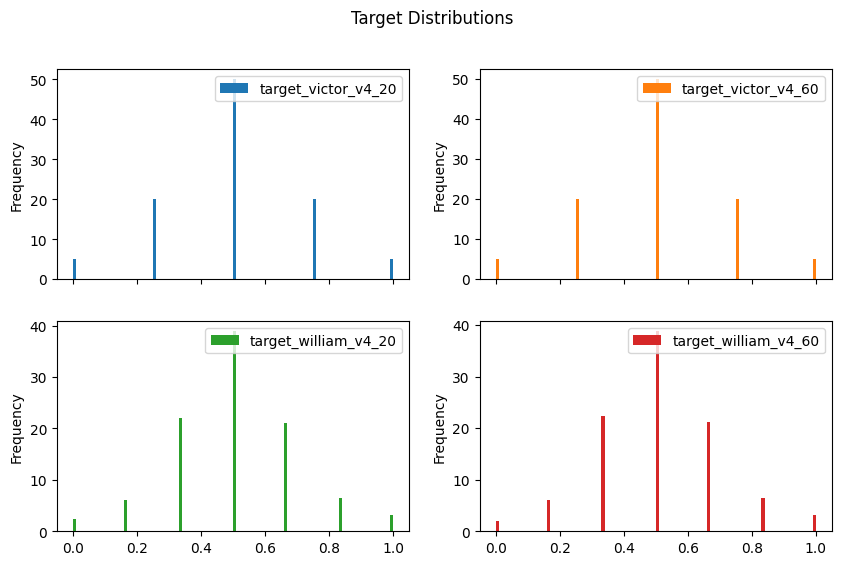

In [69]:
# It is important to note that some targets are binned into 5 bins while others are binned into 7 bins 
# But the binning for the same target name should be the same across 20 and 60 day horizons
targets_df[["target_victor_v4_20","target_victor_v4_60","target_william_v4_20","target_william_v4_60"]].plot(kind="hist", bins=100, density=True, figsize=(10, 6), title="Target Distributions", subplots=True, layout=(2, 2));

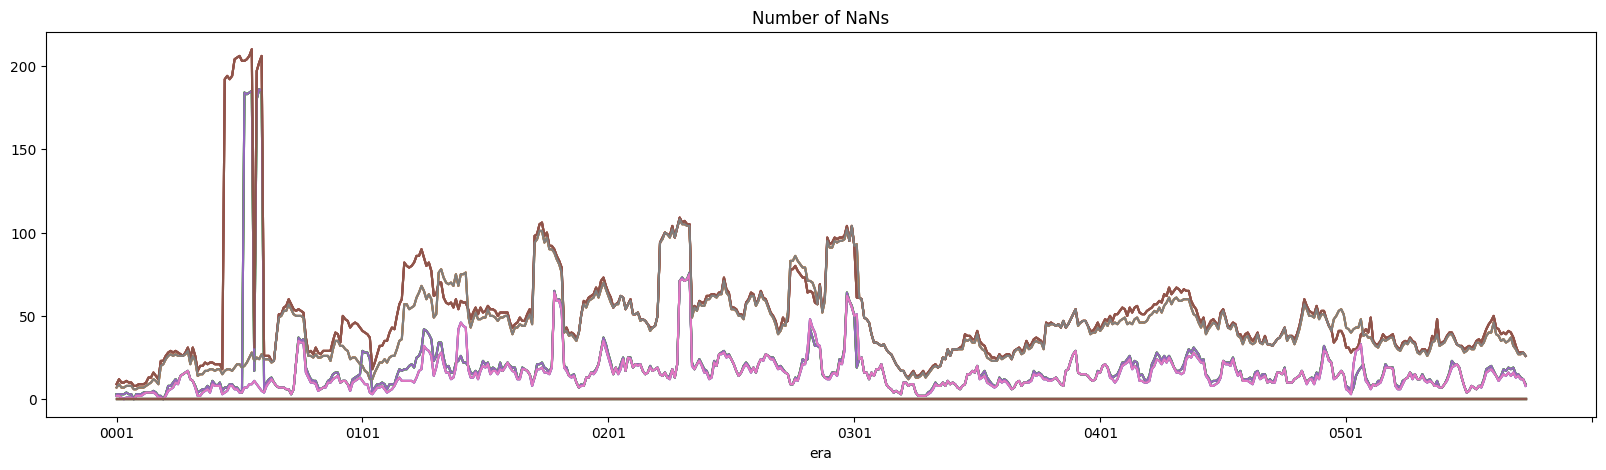

In [70]:
# It is critical to note that there can be NaN values in the auxilary targets, but the primary target will never have NaN values
# The reason why we have NaNs is because some data is just not available for some eras
# Instead of dropping these rows or imputing the values, we have chosen to leave them as NaNs to avoid any data leakage or unwanted bias
# How you handle these NaNs is up to you!
nans_per_era = targets_df.groupby("era").apply(lambda x: x.isna().sum())
nans_per_era[target_names].plot(figsize=(20, 5), title="Number of NaNs", legend=False);

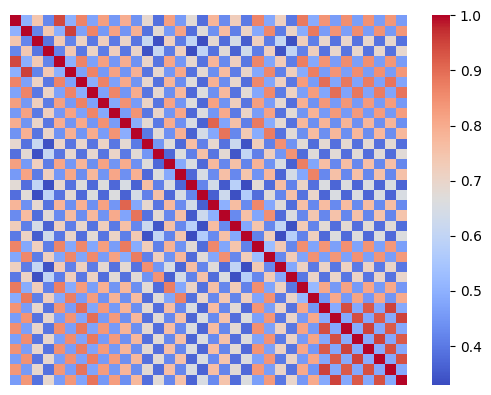

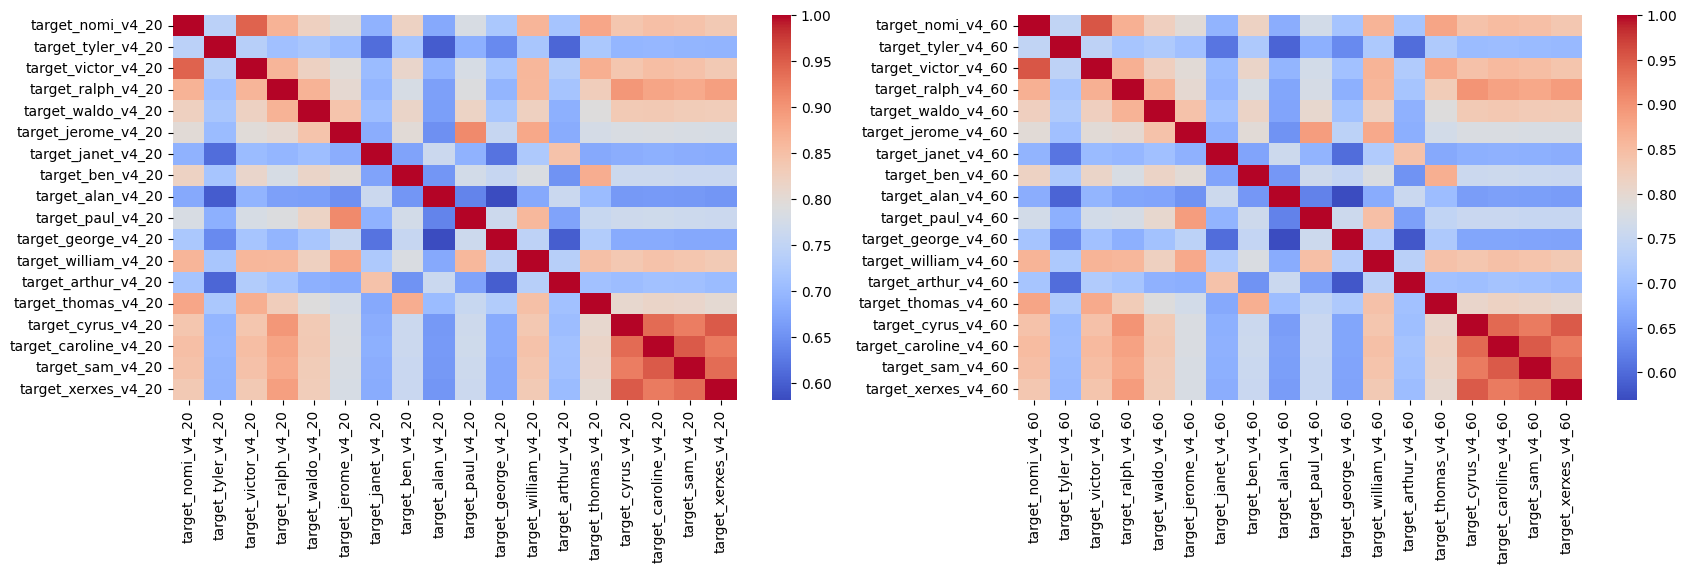

In [71]:
# The targets have a wide range of correlations with each other from ~0.3 to ~0.9
# This should allow the construction of many diverse models which ensemble nicely
import seaborn as sns
sns.heatmap(targets_df[target_names].corr(), cmap="coolwarm", xticklabels=False, yticklabels=False);

# If we only consider the correlations of targets within their own time horizon, we can see that the correlations are much higher  
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
sns.heatmap(targets_df[t20s].corr(), cmap="coolwarm", ax=ax1);
sns.heatmap(targets_df[t60s].corr(), cmap="coolwarm", ax=ax2);

## 2. Overlapping Eras 

Recall that eras in the training and validation data are each one week apart and that targets represent 20 day or 60 subsequent returns. To clarify, "days" here mean "market days" so there are only 5 days in a week. 

Putting these two ideas together, we can now see that ther eras are <ins>overlapping</ins>. The 20 day (4 week) return of era1 (week 1) span week 1-4, while the 20 day (4 week) return of era2 (week 2) span week 2-5, and so on. For 60 day (12 week) returns, the overlap of time spans are even more pronounced.

This concept of era overlap is important to keep in mind when applying cross validation. Just making sure that your test set in each split is after the train set is not enough - you need to additionally <ins>purge</ins> some eras between train and test to make sure you are not accidentally leaking any information due to this overlap.

Specifically, if you train on era1 using a 20 day target, then you must purge eras2-4, and the first era that you can safely test on is era5. If you train on era1 using a 60 day target, then you must purge eras2-12, and the first era that you can safely test on is era13.

In [72]:
import numpy as np

def get_era_wise_cv_splits(eras, n_folds=5, purge=0):
    # divide the eras into n_folds, adding any remainder eras to the last fold  
    len_fold = len(eras) // n_folds
    folds = [eras[i * len_fold : (i + 1) * len_fold] for i in range(n_folds)]
    folds[-1] = np.append(folds[-1], eras[n_folds * len_fold :])
    
    # create splits
    splits = []
    for train_fold_idx in range(n_folds-1):
        # train up to the current fold
        train = np.concatenate(folds[:train_fold_idx+1])
        # test in the next fold, purging the first `purge` eras 
        test = folds[train_fold_idx+1][purge:]
        splits.append((train, test))
        
    return splits

In [73]:
# The following code is adapted from the scikit-learn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
cmap_cv = plt.cm.Paired

def plot_cv_indices(eras, cv_splits, title):
    fig, ax = plt.subplots()
    
    # add a bar for each split where nan=unused, 0=train, 1=test
    for ii, (tr, tt) in enumerate(cv_splits):   
        df = pd.DataFrame(index=eras)
        df.loc[df.index.isin(tr), "group"] = 0
        df.loc[df.index.isin(tt), "group"] = 1
        ax.scatter(x=eras.astype(int), y=[ii + 0.5] * len(eras), c=df["group"].values, marker="_", s=1, lw=10, cmap=cmap_cv, vmin=0, vmax=2)

    # formatting
    fig.set_size_inches(8, 4)
    n_splits = len(cv_splits)
    ax.set(yticks=np.arange(n_splits) + 0.5, yticklabels=list(range(n_splits)), xlabel="era", ylabel="split", ylim=[n_splits + 0.2, -0.2])
    ax.set_title(title)
    ax.legend([Patch(color=cmap_cv(0)), Patch(color=cmap_cv(0.5))], ["Train", "Test"], loc=(1.02, 0.8))
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)

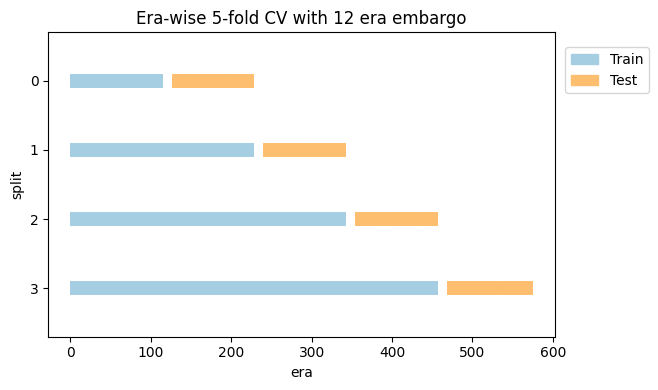

In [74]:
# Here is a visualzation of the 5-fold CV splits with a 12 era embargo suitable for models training on a 60 day target
cv_splits = get_era_wise_cv_splits(training_data["era"].unique(), n_folds=5, purge=12)
plot_cv_indices(training_data["era"].unique(), cv_splits, "Era-wise 5-fold CV with 12 era embargo");

Era-wise time series cross validation is a deep and active area of research. For more on this topic, we highly recommend that you read up on the following
- https://forum.numer.ai/t/era-wise-time-series-cross-validation/791/10
- https://www.wiley.com/en-us/Advances+in+Financial+Machine+Learning-p-9781119482086

In [75]:
def get_time_series_cross_val_splits(data, cv=3, embargo=12):
    all_train_eras = data["era"].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [
        all_train_eras[i * len_split : (i + 1) * len_split] for i in range(cv)
    ]
    # fix the last test split to have all the last eras, in case the number of eras wasn't divisible by cv
    remainder = len(all_train_eras) % cv
    if remainder != 0:
        test_splits[-1] = np.append(test_splits[-1], all_train_eras[-remainder:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren't in the test split
        train_split_not_embargoed = [
            e
            for e in all_train_eras
            if not (test_split_min <= int(e) <= test_split_max)
        ]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let's embargo everything by 60/5 == 12 eras.
        train_split = [
            e
            for e in train_split_not_embargoed
            if abs(int(e) - test_split_max) > embargo
            and abs(int(e) - test_split_min) > embargo
        ]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip